# Domain-Adversarial Neural Network (DANN) for Glacier Mass Balance Prediction

This notebook implements **Domain-Adversarial Neural Networks (DANN)** for predicting glacier point mass balance measurements using meteorological and topographical features. DANN enables cross-regional transfer learning by learning domain-invariant features while maintaining prediction accuracy.

## **Modelling Strategy: Cross-Regional Transfer Learning**

### **Domain-Adversarial Transfer Learning (Switzerland → Norway)**
- Combines data from Swiss glaciers (source domain) and Norwegian glaciers (target domain)
- Uses gradient reversal layer to learn domain-invariant features
- Enables knowledge transfer from data-rich Swiss glaciers to Norwegian glaciers
- Balances regression loss (mass balance prediction) with domain classification loss

---

## **Prerequisites**
- Norwegian glacier dataset from `../1.1. Norway-prepro.ipynb`
- Swiss glacier dataset from `regions/Switzerland/1.1. GLAMOS-prepro.ipynb`
- ERA5 climate data for both regions from `../1.2. ERA5Land-prepro.ipynb`

---

### Feature Definitions

**Climate Features (ERA5 Reanalysis):**
- `t2m`: 2-meter temperature
- `tp`: Total precipitation
- `slhf`/`sshf`: Surface heat fluxes
- `ssrd`: Surface solar radiation downwards
- `fal`: Albedo
- `str`: Surface net thermal radiation
- `u10`/`v10`: Wind components

**Topographical Features (OGGM):**
- `aspect`/`slope`: Terrain geometry
- `hugonnet_dhdt`: Ice thickness changes
- `consensus_ice_thickness`: Ice depth
- `millan_v`: Ice surface velocity
- `elevation_difference`: Measurement elevation − ERA5-Land grid cell elevation

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.norway_preprocess import *
from scripts.plots import *
from scripts.config_NOR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.NorwayConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",
]

In [ ]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

else:
    print("CUDA is NOT available")


CUDA is available


### Create Combined Swiss and Norway Glacier Dataset

Start with point mass balance measurements and transform them to monthly format with ERA5 climate data.

In [4]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_NOR = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm_with_millanv.csv')

# Drop Nan entries in millan_v of Norway dataset
data_NOR = data_NOR.dropna(subset=data_NOR.columns.drop('DATA_MODIFICATION'))
display(data_NOR)

display(data_CH.columns)

display(data_NOR.columns)

data_CH = data_CH.drop(['aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with NOR
data_NOR_CH = pd.concat([data_NOR, data_CH], axis=0).reset_index(drop=True)

display(data_NOR_CH.head(2))

display(len(data_NOR_CH['GLACIER'].unique()))

,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,POINT_ID,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v
7,67.31103,16.04244,942,20120925,20130927,-5.63,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,303.724524,17.264116,946.701050,-2.321560,56.485962,69.698883
8,67.30629,16.05432,1089,20120925,20130927,-3.83,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.30629_16.05432_N_...,332.405609,2.198246,1088.740723,-1.424430,147.849106,13.431213
9,67.30809,16.07252,1093,20120925,20130927,-3.02,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.30809_16.07252_N_...,38.497514,3.836923,1090.195312,-1.584609,128.302780,31.785975
10,67.29883,16.08302,1153,20120925,20130927,-3.56,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.29883_16.08302_N_...,355.618198,3.476761,1152.887817,-1.078567,118.048553,55.155796
11,67.29155,16.06082,1256,20120925,20130927,-2.51,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.29155_16.06082_N_...,349.840923,1.787641,1254.803467,-1.107427,258.436462,26.527679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6269,61.74291,7.14345,1796,19611001,19620513,2.38,winter,RGI60-08.01126,1962,Nigardsbreen,Filled missing FROM_DATE with October 1st of p...,Nigardsbreen_1962_winter_61.74291_7.14345_N_N_...,181.776838,7.609763,1793.964722,-0.510832,176.193283,14.855300
6270,61.69387,7.11652,1579,19611001,19620513,2.76,winter,RGI60-08.01126,1962,Nigardsbreen,Filled missing FROM_DATE with October 1st of p...,Nigardsbreen_1962_winter_61.69387_7.11652_N_N_...,81.210212,13.313894,1570.454346,-0.178745,125.875511,22.823906
6272,68.33479,17.85005,1092,19661020,19670520,1.86,winter,RGI60-08.02436,1967,Blaaisen,Changed TO_DATE year fomr 1966 to 1967,Blaaisen_1967_winter_68.33479_17.85005_N_N_4155,29.882699,17.255500,1050.585938,-1.058776,36.787617,43.074333
6273,61.71461,7.11601,1587,19631001,19640507,2.01,winter,RGI60-08.01126,1964,Nigardsbreen,Changed TO_DATE year fomr 1963 to 1964,Nigardsbreen_1964_winter_61.71461_7.11601_N_N_...,151.305943,4.883604,1586.242676,-1.184982,197.545349,35.713974


Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER',
       'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v'],
      dtype='object')

,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,POINT_ID,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v
0,67.31103,16.04244,942.0,20120925,20130927,-5.63,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,303.724524,17.264116,946.701050,-2.32156,56.485962,69.698883
1,67.30629,16.05432,1089.0,20120925,20130927,-3.83,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.30629_16.05432_N_...,332.405609,2.198246,1088.740723,-1.42443,147.849106,13.431213


70

### Dataset Transformation to Monthly Format

Transform point mass balance data to monthly resolution, integrate with ERA5 climate variables, and assign domain labels for adversarial training.

In [ ]:
data_CH_NOR_test = data_NOR_CH.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_NOR_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_NOR_wgms_dataset_monthly_full_with_millanv_v2.csv')
data_monthly_CH_NOR = dataloader_gl.data

# Add DOMAIN column back using RGI ID patterns
def assign_domain(rgi_id):
    if rgi_id.startswith('RGI60-11'):
        return 0  # Switzerland
    elif rgi_id.startswith('RGI60-08'):
        return 1  # Norway
    else:
        return -1  # Unknown

data_monthly_CH_NOR['DOMAIN'] = data_monthly_CH_NOR['RGIId'].apply(assign_domain)

# Verify domain assignment
print("Domain distribution after assignment:")
print(data_monthly_CH_NOR['DOMAIN'].value_counts())
print(f"Unknown domains (-1): {(data_monthly_CH_NOR['DOMAIN'] == -1).sum()}")

# Update the dataloader with the new data including DOMAIN
dataloader_gl.data = data_monthly_CH_NOR

display(data_monthly_CH_NOR.head(2))

# Ensure DOMAIN is part of metadata (so it travels with AggregatedDataset)
if 'DOMAIN' not in cfg.metaData:
    cfg.metaData = cfg.metaData + ['DOMAIN']
print('Metadata columns now:', cfg.metaData)

2025-09-12 18:59:44,400 - INFO - Loaded preprocessed data.
2025-09-12 18:59:44,403 - INFO - Number of monthly rows: 347647
2025-09-12 18:59:44,444 - INFO - Number of annual samples: 123790
2025-09-12 18:59:44,485 - INFO - Number of winter samples: 223857


Domain distribution after assignment:
DOMAIN
0    290682
1     56965
Name: count, dtype: int64
Unknown domains (-1): 0


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10,DOMAIN
0,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942.0,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,-3.957367,0.002545,-120958.0,132238.0,2673505.0,0.518889,-2003158.0,-0.577771,0.414947,1
1,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942.0,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,-7.107025,0.003408,107086.0,467112.0,414668.0,0.838310,-1135388.0,-1.247729,1.351297,1


### Train/Test Splitting

**Domain-Aware Spatial Generalization:** Select training set from Swiss glaciers plus a subset of  Norwegian glaciers, with remaining Norwegian glaciers being the test set.

In [8]:
# 4 glaciers 50%
#train_glaciers_NOR_subset = ['Engabreen', 'Nigardsbreen', 'Aalfotbreen', 'Graasubreen']
"""
# 50% Kmeans
train_glaciers_NOR_subset = ['Engabreen',
 'Storglombreen N',
 'Moesevassbrea',
 'Blaaisen',
 'Blabreen',
 'Harbardsbreen',
 'Graasubreen',
 'Svelgjabreen',
 'Aalfotbreen',
 'Rundvassbreen',
 'Juvfonne',
 'Storsteinsfjellbreen',
 'Hansebreen',
 'Vesledalsbreen',
 'Vetlefjordbreen',
 'Blomstoelskardsbreen',
 'Vestre Memurubreen',
 'Austre Memurubreen']
"""
# 7 glaciers 5-10%
train_glaciers_NOR_subset = ['Tunsbergdalsbreen','Austre Memurubreen','Svartisheibreen','Bondhusbrea','Harbardsbreen','Moesevassbrea','Graasubreen']

"""
# 63 lat split
train_glaciers_NOR_subset = ['Aalfotbreen', 'Austdalsbreen', 'Austre Memurubreen', 'Blabreen', 'Blomstoelskardsbreen',
                    'Bondhusbrea', 'Breidablikkbrea', 'Graafjellsbrea', 'Graasubreen', 'Hansebreen', 'Harbardsbreen',
                    'Hellstugubreen', 'Juvfonne', 'Moesevassbrea', 'Nigardsbreen', 'Rembesdalskaaka', 'Ruklebreen',
                    'Svelgjabreen', 'Tunsbergdalsbreen', 'Vesledalsbreen', 'Vestre Memurubreen', 'Vetlefjordbreen']
"""

# Define training glaciers: All CH + subset of NOR for DANN
train_glaciers_CH = list(data_CH['GLACIER'].unique())
train_glaciers = train_glaciers_CH + train_glaciers_NOR_subset

# Define test glaciers: Remaining NOR glaciers (not in training subset)
test_glaciers = [g for g in data_NOR['GLACIER'].unique() if g not in train_glaciers_NOR_subset]

# Ensure all glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_train = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_train:
    print(f"Warning: The following training glaciers are not in the dataset: {missing_train}")
if missing_test:
    print(f"Warning: The following test glaciers are not in the dataset: {missing_test}")

# Get training and test data
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(train_glaciers)]
display(data_train)
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('DANN Training Setup:')
print(f'  Swiss training glaciers: {len(train_glaciers_CH)}')
print(f'  Norwegian training subset: {len(train_glaciers_NOR_subset)} - {train_glaciers_NOR_subset}')
print(f'  Total training glaciers: {len(train_glaciers)}')
print(f'  Norwegian test glaciers: {len(test_glaciers)}')
print(f'Size of train data: {len(data_train)}')
print(f'Size of test data: {len(data_test)}')

# Check domain distribution in training set
print(f'Training domain distribution:')
print(data_train['DOMAIN'].value_counts())

# CV Splits for DANN
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10,DOMAIN
4951,2017,6.23614,59.958500,-3.110,903.802191,144.197809,1048.000000,RGI60-08.02920,Moesevassbrea_2017_annual_59.9585_6.23614_N_N_...,496,...,1.572174,0.003777,-395486.0,390246.0,5712103.0,0.618483,-2601208.0,-1.033231,-0.056030,1
4952,2017,6.23614,59.958500,-3.110,903.802191,144.197809,1048.000000,RGI60-08.02920,Moesevassbrea_2017_annual_59.9585_6.23614_N_N_...,496,...,-4.637054,0.007868,-67966.0,357024.0,1700736.0,0.727363,-1501804.0,-0.855687,0.249116,1
4953,2017,6.23614,59.958500,-3.110,903.802191,144.197809,1048.000000,RGI60-08.02920,Moesevassbrea_2017_annual_59.9585_6.23614_N_N_...,496,...,-1.432953,0.014975,-24388.0,327584.0,463108.0,0.734155,-638912.0,-0.091323,0.792321,1
4954,2017,6.23614,59.958500,-3.110,903.802191,144.197809,1048.000000,RGI60-08.02920,Moesevassbrea_2017_annual_59.9585_6.23614_N_N_...,496,...,-4.487640,0.007993,-50622.0,253364.0,1180252.0,0.742099,-1347558.0,-0.663486,0.443136,1
4955,2017,6.23614,59.958500,-3.110,903.802191,144.197809,1048.000000,RGI60-08.02920,Moesevassbrea_2017_annual_59.9585_6.23614_N_N_...,496,...,-4.484222,0.006945,-97294.0,426220.0,3672060.0,0.735667,-1789695.0,-1.093056,0.198145,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347642,2003,8.47524,46.535284,-1.998,2171.442724,531.139915,2702.582638,RGI60-11.01522,witenwasseren_1,39316,...,-3.171478,0.003812,-653086.0,-1620794.0,20613876.0,0.676411,-3674161.0,0.171637,-0.126322,0
347643,2003,8.47524,46.535284,-1.998,2171.442724,531.139915,2702.582638,RGI60-11.01522,witenwasseren_1,39316,...,3.248199,0.003879,-244852.0,-1247730.0,21740796.0,0.574618,-2969440.0,0.122689,0.119759,0
347644,2003,8.47524,46.535284,-1.998,2171.442724,531.139915,2702.582638,RGI60-11.01522,witenwasseren_1,39316,...,10.955475,0.005219,-2339854.0,-1488806.0,22393936.0,0.366976,-3366256.0,0.218174,-0.193396,0
347645,2003,8.47524,46.535284,-1.998,2171.442724,531.139915,2702.582638,RGI60-11.01522,witenwasseren_1,39316,...,10.427399,0.005787,-7321654.0,-3450182.0,21336846.0,0.169596,-5809211.0,0.187729,-0.488665,0


DANN Training Setup:
  Swiss training glaciers: 39
  Norwegian training subset: 7 - ['Tunsbergdalsbreen', 'Austre Memurubreen', 'Svartisheibreen', 'Bondhusbrea', 'Harbardsbreen', 'Moesevassbrea', 'Graasubreen']
  Total training glaciers: 46
  Norwegian test glaciers: 24
Size of train data: 296484
Size of test data: 51163
Training domain distribution:
DOMAIN
0    290682
1      5802
Name: count, dtype: int64
Train glaciers: (46) ['Moesevassbrea' 'Svartisheibreen' 'Harbardsbreen' 'Graasubreen'
 'Tunsbergdalsbreen' 'Austre Memurubreen' 'Bondhusbrea' 'adler' 'albigna'
 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen' 'clariden'
 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro' 'gorner'
 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar'
 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna' 'sardona'
 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta' 'taelliboden' 'tiefen'
 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Test glaciers: (24) ['Rundv

### Training/Validation Split Strategy (80/20)

**Standard Approach:** Random 80/20 split across all available training data (Swiss + Norwegian training glaciers).

In [9]:
# Validation and train split for DANN:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and validation dataset
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values
domain_train = df_X_train['DOMAIN'].values  # Extract domain labels

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values
domain_val = df_X_val['DOMAIN'].values  # Extract domain labels

print("Train indices (first 10):", train_indices[:10])
print("Val indices (first 10):", val_indices[:10])
print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)
print("Train domain distribution:", pd.Series(domain_train).value_counts())
print("Val domain distribution:", pd.Series(domain_val).value_counts())

Train indices (first 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Val indices (first 10): [22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Train data glacier distribution: GLACIER
rhone        44827
silvretta    35896
findelen     26732
gries        20442
aletsch      13022
Name: count, dtype: int64
Val data glacier distribution: GLACIER
rhone        11246
silvretta     8581
findelen      6825
gries         5261
aletsch       3247
Name: count, dtype: int64
Train data shape: (267031, 30)
Val data shape: (66960, 30)
Train domain distribution: 0    232747
1     34284
Name: count, dtype: int64
Val domain distribution: 0    57923
1     9037
Name: count, dtype: int64


### Training/Validation Split - Target Domain Focus (80/20)

**Domain-Aware Approach:** This split will only build the validation set from Norwegian data

- **Training Set:** All Swiss data + 80% of Norwegian training glaciers
- **Validation Set:** 20% of Norwegian training glaciers only

In [9]:
# Full training pool = CH + Norway subset
data_train = train_set['df_X'].copy()
data_train['y'] = train_set['y']

# Norway train_glaciers
norway_train_glacier = [
    g for g in data_NOR['GLACIER'].unique()
    if g not in test_glaciers
]
display('train glaciers from target domain: ', norway_train_glacier)

# Find Norway subset within this pool
norway_mask = data_train['GLACIER'].isin(norway_train_glacier)
data_norway = data_train.loc[norway_mask]

# Split only the Norway subset
dataloader = mbm.dataloader.DataLoader(cfg, data=data_norway)
train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

norway_train_idx = list(train_itr)
norway_val_idx = list(val_itr)

# Training set = CH + Norway train portion
df_X_train = pd.concat([
    data_train.loc[~norway_mask],                           # all CH glaciers
    data_norway.iloc[norway_train_idx]                    # Norway train glaciers
])
y_train = df_X_train['POINT_BALANCE'].values

# Validation set = Norway val portion only
df_X_val = data_norway.iloc[norway_val_idx]
y_val = df_X_val['POINT_BALANCE'].values


print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

'train glaciers from target domain: '

['Moesevassbrea',
 'Svartisheibreen',
 'Harbardsbreen',
 'Graasubreen',
 'Tunsbergdalsbreen',
 'Austre Memurubreen',
 'Bondhusbrea']

Train data glacier distribution: GLACIER
rhone        56073
silvretta    44477
findelen     33557
gries        25703
aletsch      16269
Name: count, dtype: int64
Val data glacier distribution: GLACIER
Austre Memurubreen    293
Tunsbergdalsbreen     255
Svartisheibreen       232
Harbardsbreen         188
Bondhusbrea           174
Name: count, dtype: int64
Train data shape: (295261, 30)
Val data shape: (1223, 30)


## Domain-Adversarial Neural Network Configuration & Training

Implementing a **Domain-Adversarial Neural Network (DANN)** 

The architecture combines:

1. **Feature Extractor:** Shared multilayer perceptron extracting domain-invariant representations
2. **Regression Head:** Predicts mass balance from extracted features  
3. **Domain Classifier:** Distinguishes between Swiss (0) and Norway (1) domains (including gradient reversal layer)

The gradient reversal layer enables adversarial training where the feature extractor learns to fool the domain classifier while maintaining prediction accuracy.

Define Features:

In [ ]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate)

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (295261, 29)
Shape of validation dataset: (1223, 29)
Shape of testing dataset: (51163, 29)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


### DANN Architecture Implementation

Implementation of Domain-Adversarial Neural Network components:
- **Gradient Reversal Layer:** Multiplies gradients by -λ during backpropagation
- **DANN Network:** Feature extractor with dual heads for regression and domain classification  
- **Custom Loss:** Combines regression loss with adversarial domain loss

In [ ]:
# DANN components: Gradient Reversal, network, regressor wrapper, and dataset bindings
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skorch.utils import to_tensor
import massbalancemachine as mbm
from pathlib import Path

# Gradient Reversal Layer
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class GradReverse(nn.Module):
    def __init__(self, lambda_=1.0):
        super().__init__()
        self.lambda_ = lambda_
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

class DANNNetwork(nn.Module):
    """
    Feature extractor identical to FlexibleNetwork's trunk, with two heads:
    - Regressor head for SMB (label)
    - Domain classifier head (binary)
    """
    def __init__(self, input_dim, hidden_layers, dropout=0.2, use_batchnorm=False, domain_hidden=64, grl_lambda=1.0):
        super().__init__()
        layers = []
        current_dim = input_dim
        if not isinstance(dropout, list):
            dropout = [dropout] * len(hidden_layers)
        for hidden_dim, drop_rate in zip(hidden_layers, dropout):
            layers.append(nn.Linear(current_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_rate))
            current_dim = hidden_dim
        # trunk outputs the last hidden representation
        self.feature_extractor = nn.Sequential(*layers)
        # heads
        self.regressor = nn.Linear(current_dim, 1)
        self.grl = GradReverse(lambda_=grl_lambda)
        self.domain_classifier = nn.Sequential(
            nn.Linear(current_dim, domain_hidden),
            nn.ReLU(),
            nn.Dropout(dropout[-1] if isinstance(dropout, list) else dropout),
            nn.Linear(domain_hidden, 1),  # logits
        )

    def forward(self, x):
        h = self.feature_extractor(x)
        y_pred = self.regressor(h)
        d_logits = self.domain_classifier(self.grl(h))
        return y_pred, d_logits

# Dataset that yields domain labels padded per ID to match monthly padding
class DomainTargetDataset(torch.utils.data.Dataset):
    def __init__(self, aggregated_dataset):
        self.base = aggregated_dataset
        self.meta_has_domain = 'DOMAIN' in self.base.metadataColumns
        if not self.meta_has_domain:
            # fallback: try to read from features
            assert 'DOMAIN' in self.base.cfg.featureColumns, "DOMAIN must be in metadata or featureColumns"
            self.domain_feat_idx = self.base.cfg.featureColumns.index('DOMAIN')
        else:
            self.domain_idx = self.base.metadataColumns.index('DOMAIN')
    def __len__(self):
        return len(self.base)
    def __getitem__(self, index):
        ind = self.base._getInd(index)
        if self.meta_has_domain:
            dval = self.base.metadata[ind[0]][self.domain_idx]
        else:
            dval = self.base.features[ind[0], self.domain_feat_idx]
        dpad = np.empty(self.base.maxConcatNb, dtype=np.float32)
        dpad.fill(np.nan)
        dpad[:len(ind)] = dval
        return dpad

# Binding that returns (X, (y, d)) so y_true in get_loss can contain both
class CombinedTargetBinding(torch.utils.data.Dataset):
    def __init__(self, X_slice, y_slice, d_dataset):
        self.X = X_slice
        self.y = y_slice
        self.d = d_dataset
        assert len(self.X) == len(self.y) == len(self.d)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], (self.y[idx], self.d[idx])

# Skorch regressor that adds domain-adversarial loss on top of the SMB loss
class CustomDANNRegressor(mbm.models.CustomNeuralNetRegressor):
    def __init__(self, cfg, *args, dan_lambda=0.1, **kwargs):
        super().__init__(cfg, *args, **kwargs)
        self.dan_lambda = dan_lambda
        self._last_domain_logits = None

    def infer(self, x, **fit_params):
        x = to_tensor(x, device=self.device)
        if len(x.shape) == 1:
            x = x[None]
        x, indNonNan = self._unpack_inp(x)
        if self.modelDtype is not None:
            x = x.type(self.modelDtype)
        outputs = self.module_(x, **fit_params)
        if isinstance(outputs, tuple):
            y_monthly, d_monthly = outputs
            y_packed = self._pack_out(y_monthly, indNonNan)
            d_packed = self._pack_out(d_monthly, indNonNan)
            self._last_domain_logits = d_packed
            return y_packed
        else:
            return self._pack_out(outputs, indNonNan)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        # y_true can be (label_pad, domain_pad) from CombinedTargetBinding
        if isinstance(y_true, (tuple, list)) and len(y_true) == 2:
            y_true_labels, y_true_domain = y_true
        else:
            y_true_labels, y_true_domain = y_true, None

        # Label loss (same as base implementation)
        loss = 0.0
        cnt = 0
        for yi_pred, yi_true in zip(y_pred, y_true_labels):
            valid = ~torch.isnan(yi_pred)
            if valid.any():
                pred_sum = yi_pred[valid].sum()
                true_mean = yi_true[valid].mean()
                loss = loss + (pred_sum - true_mean) ** 2
                cnt += 1
        label_loss = loss / max(cnt, 1)

        """"
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits
            mask = ~torch.isnan(y_true_domain)
            if mask.any():
                domain_loss = F.binary_cross_entropy_with_logits(d_logits[mask], y_true_domain[mask].float())
        """
        """
        # Domain loss a bit more complicated due to Per-ID mean and then batch mean, otherwise IDs with longer months have higher domain loss
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits  # shape: [batch, max_months] (or [batch, max_months, 1])
            per_id_losses = []
            for d_log_row, d_true_row in zip(d_logits, y_true_domain):
                # squeeze trailing dim if present
                if d_log_row.ndim > 1:
                    d_log_row = d_log_row.squeeze(-1)

                # mask valid months
                mask = ~torch.isnan(d_true_row) # Select valid months per ID, NaN padding months are False
                if mask.any():
                    loss_i = F.binary_cross_entropy_with_logits(
                        d_log_row[mask],
                        d_true_row[mask].float(),
                        reduction='mean',  # mean over valid months for this ID
                    )
                    per_id_losses.append(loss_i)

            if len(per_id_losses) > 0:
                domain_loss = torch.stack(per_id_losses).mean()  # mean over IDs
        """
        # Domain loss a bit more complicated due to Per-ID mean and then batch mean for each domain
        # otherwise IDs with longer months have higher domain loss and CH domain loss with more data is exaggerated
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits  # [batch_ids, max_months(,1)]
            per_id_losses_ch, per_id_losses_nor = [], []

            for d_log_row, d_true_row in zip(d_logits, y_true_domain):
                if d_log_row.ndim > 1:
                    d_log_row = d_log_row.squeeze(-1)

                mask = ~torch.isnan(d_true_row)  # Select valid months per ID, NaN padding months are False
                if mask.any():
                    loss_i = F.binary_cross_entropy_with_logits(
                        d_log_row[mask],
                        d_true_row[mask].float(),
                        reduction='mean',  # mean over valid months for this ID
                    )
                    # domain for this ID (same across valid months)
                    dom_i = int(d_true_row[mask][0].item())  # 0=CH, 1=NOR
                    (per_id_losses_ch if dom_i == 0 else per_id_losses_nor).append(loss_i)

            parts = []
            if len(per_id_losses_ch) > 0:
                parts.append(torch.stack(per_id_losses_ch).mean())
            if len(per_id_losses_nor) > 0:
                parts.append(torch.stack(per_id_losses_nor).mean())
            if len(parts) > 0:
                domain_loss = torch.stack(parts).mean()

        return label_loss + self.dan_lambda * domain_loss

    @staticmethod
    def load_model(cfg, fname: str, *args, **kwargs):
        """Loads a pre-trained DANN model from a file."""
        model = CustomDANNRegressor(cfg, *args, **kwargs)
        model.initialize()
        models_dir = Path("./models")
        model.load_params(f_params=models_dir / fname)
        return model

### Network Initialization & Hyperparameters

**DANN Configuration:**
- **Learning Rate:** 0.001 with ReduceLROnPlateau scheduling
- **Batch Size:** 128 samples per gradient update
- **Optimization:** Adam optimizer with L2 weight decay (1e-5)
- **Architecture:** [128, 128, 64, 32] hidden layers with 20% dropout
- **Domain Adversarial Loss Weight (λ):** 0.05 for balanced training
- **Domain Classifier:** 64 neurons with gradient reversal

**Callbacks for Robust Training:**
- **Early Stopping:** Prevents overfitting by monitoring validation loss (patience=15)
- **Learning Rate Scheduler:** Reduces LR when validation loss plateaus

In [29]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=10,
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter


def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)

params = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
    'module__domain_hidden': 64,
    'module__grl_lambda': 1.0,
}

# Use DANN network
args = {
    'module': DANNNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__hidden_layers': params['module__hidden_layers'],
    'module__use_batchnorm': params['module__use_batchnorm'],
    'module__domain_hidden': params['module__domain_hidden'],
    'module__grl_lambda': params['module__grl_lambda'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 200,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}

# DANN loss weight
DAN_LAMBDA = 0.1
custom_nn = CustomDANNRegressor(cfg, dan_lambda=DAN_LAMBDA, **args, **param_init)

### Dataset Preparation for DANN Training

Create aggregated datasets with domain labels and configure domain-balanced sampling

In [30]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the aggregated datasets
agg_train = mbm.data_processing.AggregatedDataset(cfg,
                                                  features=features,
                                                  metadata=metadata,
                                                  targets=y_train)
agg_val = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features_val,
                                                metadata=metadata_val,
                                                targets=y_val)

# Build domain targets per ID
domain_train_ds = DomainTargetDataset(agg_train)
domain_val_ds = DomainTargetDataset(agg_val)

# Slice features/labels
X_train_slice = SliceDataset(agg_train, idx=0)
y_train_slice = SliceDataset(agg_train, idx=1)
X_val_slice = SliceDataset(agg_val, idx=0)
y_val_slice = SliceDataset(agg_val, idx=1)

# Bind (X, (y, d)) so CustomDANNRegressor receives both labels and domains
dataset = CombinedTargetBinding(X_train_slice, y_train_slice, domain_train_ds)
dataset_val = CombinedTargetBinding(X_val_slice, y_val_slice, domain_val_ds)

# For info
print("train:", len(dataset))
print("validation:", len(dataset_val))

train: 33842
validation: 121


### Domain-Balanced Sampling Configuration

Implement WeightedRandomSampler to ensure balanced representation of Swiss and French glaciers during training, preventing domain imbalance from affecting adversarial learning.

In [ ]:
# Domain-balanced sampling (~50/50 CH:ICE) using WeightedRandomSampler
import numpy as np
import torch
from torch.utils.data import WeightedRandomSampler

# Map each training aggregated item (ID) to its DOMAIN
# 1) get the ID per aggregated sample in the training SliceDataset
train_ids = X_train_slice.dataset.indexToId(list(range(len(X_train_slice))))

# 2) build an ID -> DOMAIN dict from the training dataframe
id_to_domain = (
    df_X_train_subset.groupby('ID')['DOMAIN'].first().to_dict()
)

# 3) lookup domains per training aggregated item
sample_domains = np.array([id_to_domain.get(i, -1) for i in train_ids], dtype=int)

# Safety: ensure only CH(0) and ICE(1) are present; any other values get zero weight
n_ch = int((sample_domains == 0).sum())
n_ice = int((sample_domains == 1).sum())
if (n_ch + n_ice) == 0:
    raise ValueError("No CH/ICE samples found in training set for sampler.")

# Compute weights so the expected sampling is 50% CH and 50% ICE per epoch
w = np.zeros_like(sample_domains, dtype=float)
if n_ch > 0:
    w[sample_domains == 0] = 0.5 / n_ch
if n_ice > 0:
    w[sample_domains == 1] = 0.5 / n_ice
# Any unknown domains remain with weight 0 (won't be sampled)

sampler = WeightedRandomSampler(
    weights=torch.as_tensor(w, dtype=torch.double),
    num_samples=len(w),   # one epoch worth of samples, drawn with replacement
    replacement=True,
)

# Sanity Check
# Single simulated epoch
sim_idx = list(iter(WeightedRandomSampler(torch.as_tensor(w, dtype=torch.double),
                                         num_samples=len(w),
                                         replacement=True)))
sim_ratio = (sample_domains[sim_idx] == 1).mean()  # ICE share
print(f"Simulated epoch: ICE share={sim_ratio:.3f}, unique IDs drawn={len(set(sim_idx))}/{len(w)}")

for t in range(3):
    idx_t = list(iter(WeightedRandomSampler(torch.as_tensor(w, dtype=torch.double),
                                           num_samples=len(w),
                                           replacement=True)))
    print(f" trial {t+1}: ICE={(sample_domains[idx_t] == 1).mean():.3f}, unique={len(set(idx_t))}")


custom_nn = custom_nn.set_params(
    iterator_train__sampler=sampler,
    iterator_train__shuffle=False,
    iterator_train__batch_sampler=None,
)

print(f"Sampler configured: CH IDs={n_ch}, ICE IDs={n_ice}, total train items={len(w)}")

Simulated epoch: ICE share=0.502, unique IDs drawn=13698/33842
 trial 1: ICE=0.495, unique=13888
 trial 2: ICE=0.498, unique=13837
 trial 3: ICE=0.502, unique=13752
Sampler configured: CH IDs=33358, ICE IDs=484, total train items=33842


### Model Training & Checkpointing

Set `TRAIN = True` to train new DANN model with adversarial loss.

Training the DANN model...
Model parameters:
module: DANNNetwork
nbFeatures: 15
module__input_dim: 15
module__dropout: 0.2
module__hidden_layers: [128, 128, 64, 32]
module__use_batchnorm: True
module__domain_hidden: 64
module__grl_lambda: 1.0
train_split: <function my_train_split at 0x72e3767d4400>
batch_size: 128
verbose: 1
iterator_train__shuffle: True
lr: 0.001
max_epochs: 200
optimizer: <class 'torch.optim.adam.Adam'>
optimizer__weight_decay: 1e-05
callbacks: [('early_stop', <skorch.callbacks.training.EarlyStopping object at 0x72e3941ee110>), ('lr_scheduler', <skorch.callbacks.lr_scheduler.LRScheduler object at 0x72e364d1a090>)]
dan_lambda: 0.1
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1        1.2754        0.9023  0.0010  44.9005
      2        0.7638        0.6639  0.0010  39.6385
      3        0.6801        0.5549  0.0010  41.4692
      4        0.5940        0.4176  0.0010  40.3089
      5        0.5813    

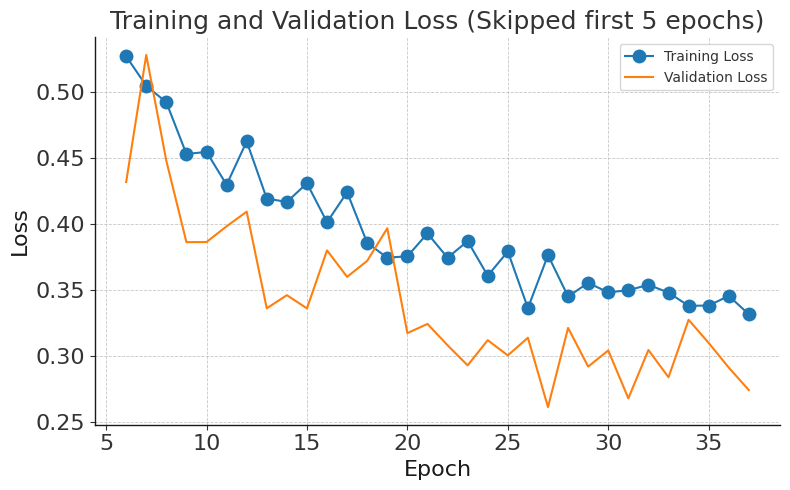

In [ ]:
TRAIN = True
if TRAIN:
    custom_nn.seed_all()

    print("Training the DANN model...")
    print('Model parameters:')
    for key, value in args.items():
        if key == 'module':
            print(f"{key}: DANNNetwork")
        else:
            print(f"{key}: {value}")
    print(f"dan_lambda: {DAN_LAMBDA}")
    custom_nn.fit(dataset, None)


    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"dann_model_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # Save the model
    custom_nn.save_model(model_filename)
    
    # save params dic
    params_filename = f"dann_params_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump({**args, 'dan_lambda': DAN_LAMBDA}, f)

else:
    # Load model and set to CPU
    model_filename = "dann_model_2025-08-19_2nd_try_4_glaciers_50%_lamba0_05_mean_domainloss_even_domainloss_only_NOR_val.pt"  # Replace if needed
    loaded_model = CustomDANNRegressor.load_model(
        cfg,
        model_filename,
        **{
            **args,
            **param_init
        },
    )
    loaded_model = loaded_model.set_params(device='cpu')
    loaded_model = loaded_model.to('cpu')

Load previously trained DANN model.

In [33]:
# Load model and set to CPU
model_filename = "dann_model_2025-09-12_5-10%_lambda0_1_mean_domainloss_even_domainloss_only_NOR_val_50_50_epochsplit.pt"  # Replace if needed
loaded_model = CustomDANNRegressor.load_model(
    cfg,
    model_filename,
    **{
        **args,
        **param_init
    },
)
loaded_model = loaded_model.set_params(device='cpu')
loaded_model = loaded_model.to('cpu')

### Model Evaluation & Prediction Analysis

In [34]:
# Create features and metadata
# IMPORTANT: ensure 'DOMAIN' is NOT part of feature_columns (keep it in cfg.metaData)
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

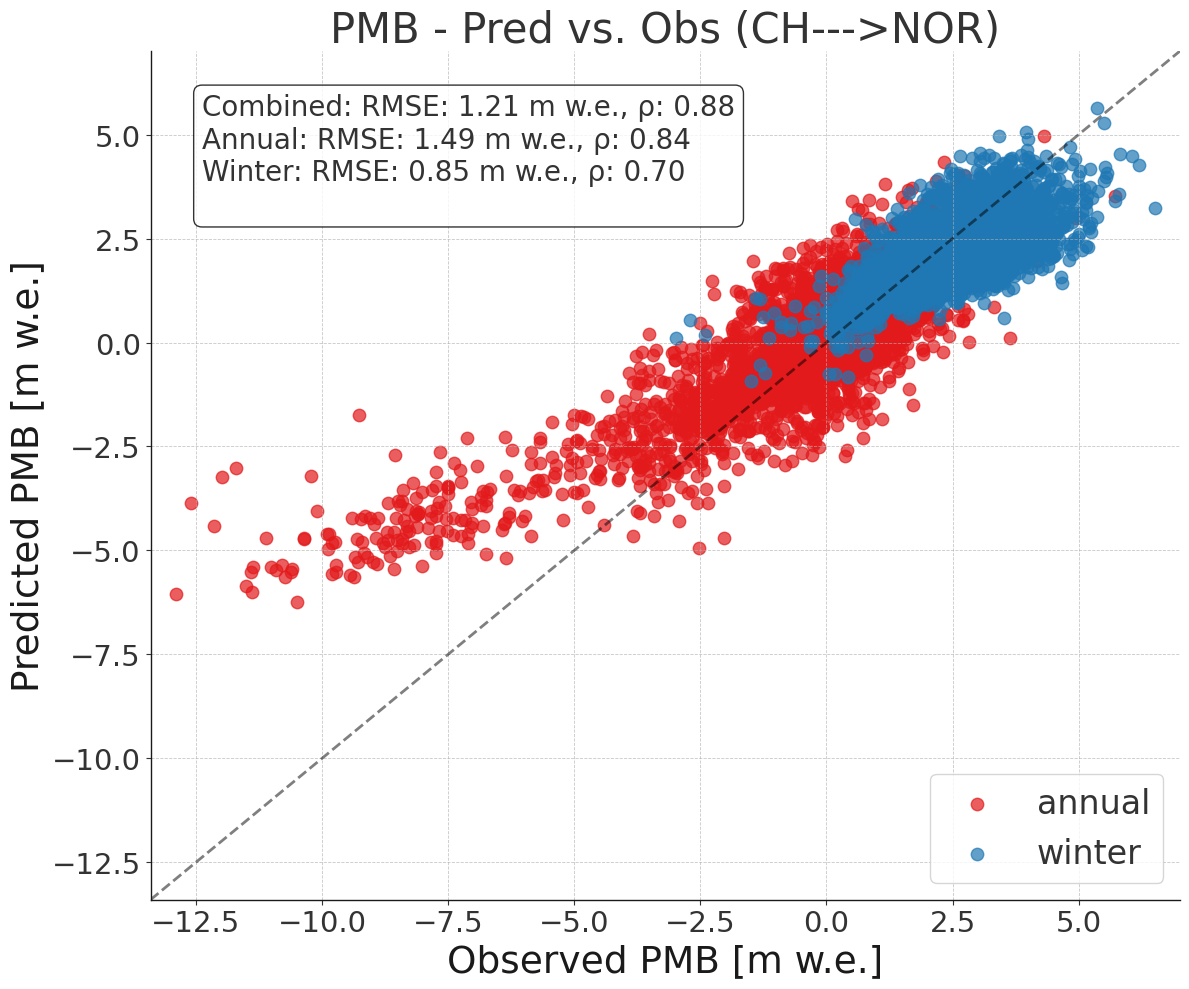

In [ ]:
PlotPredictionsCombined_NN_additional(grouped_ids)

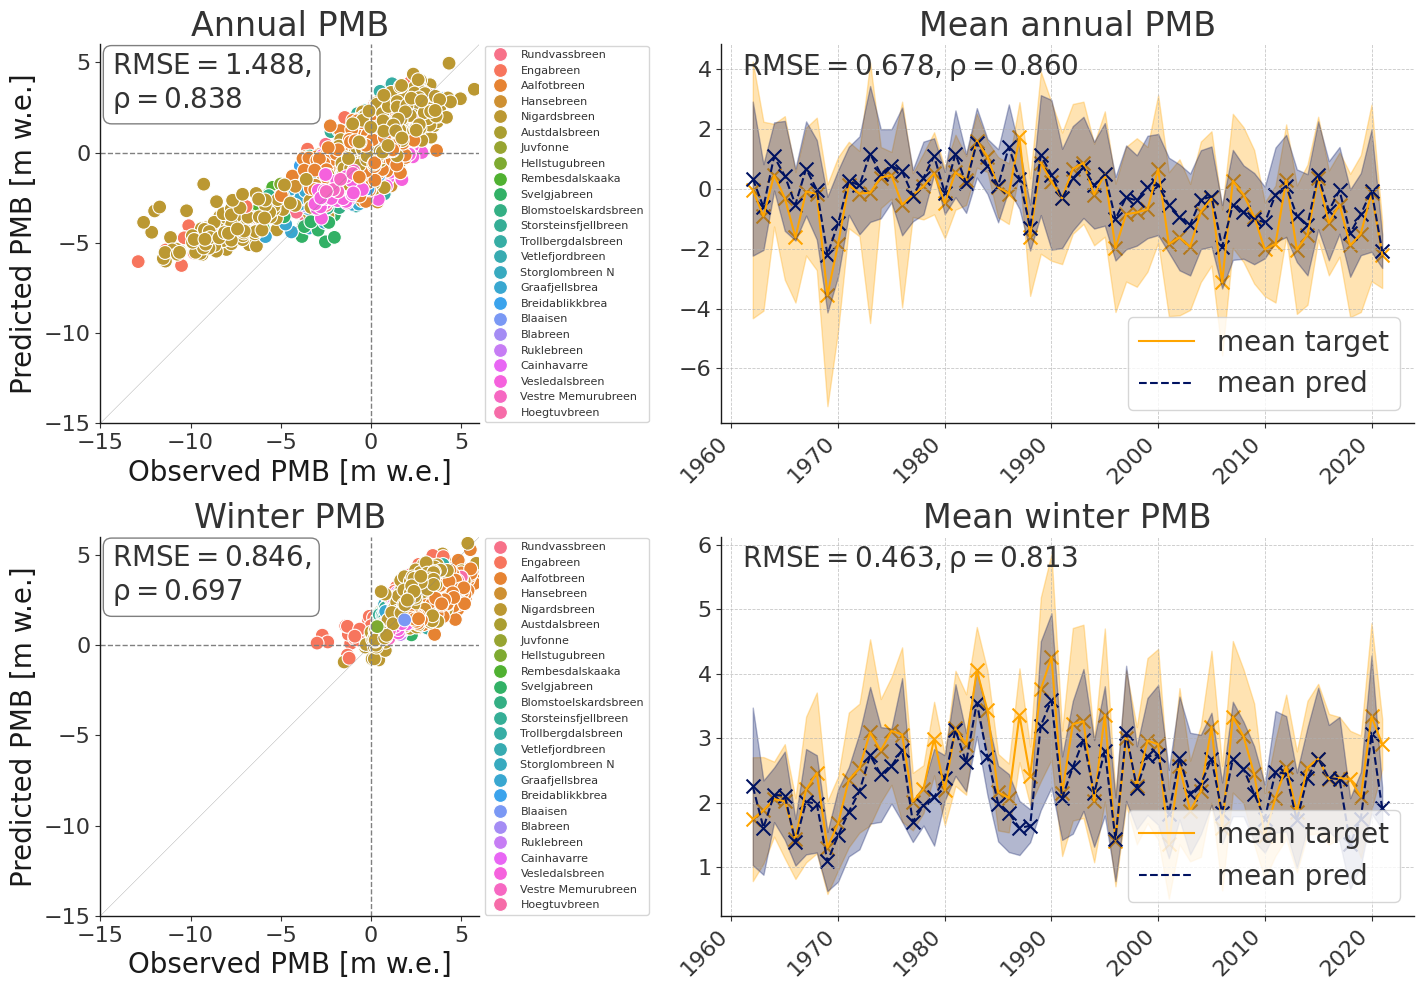

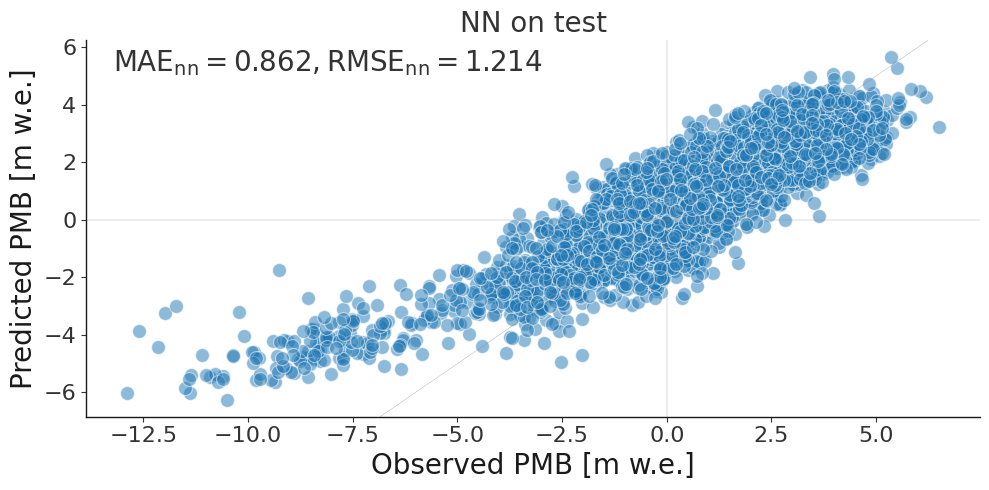

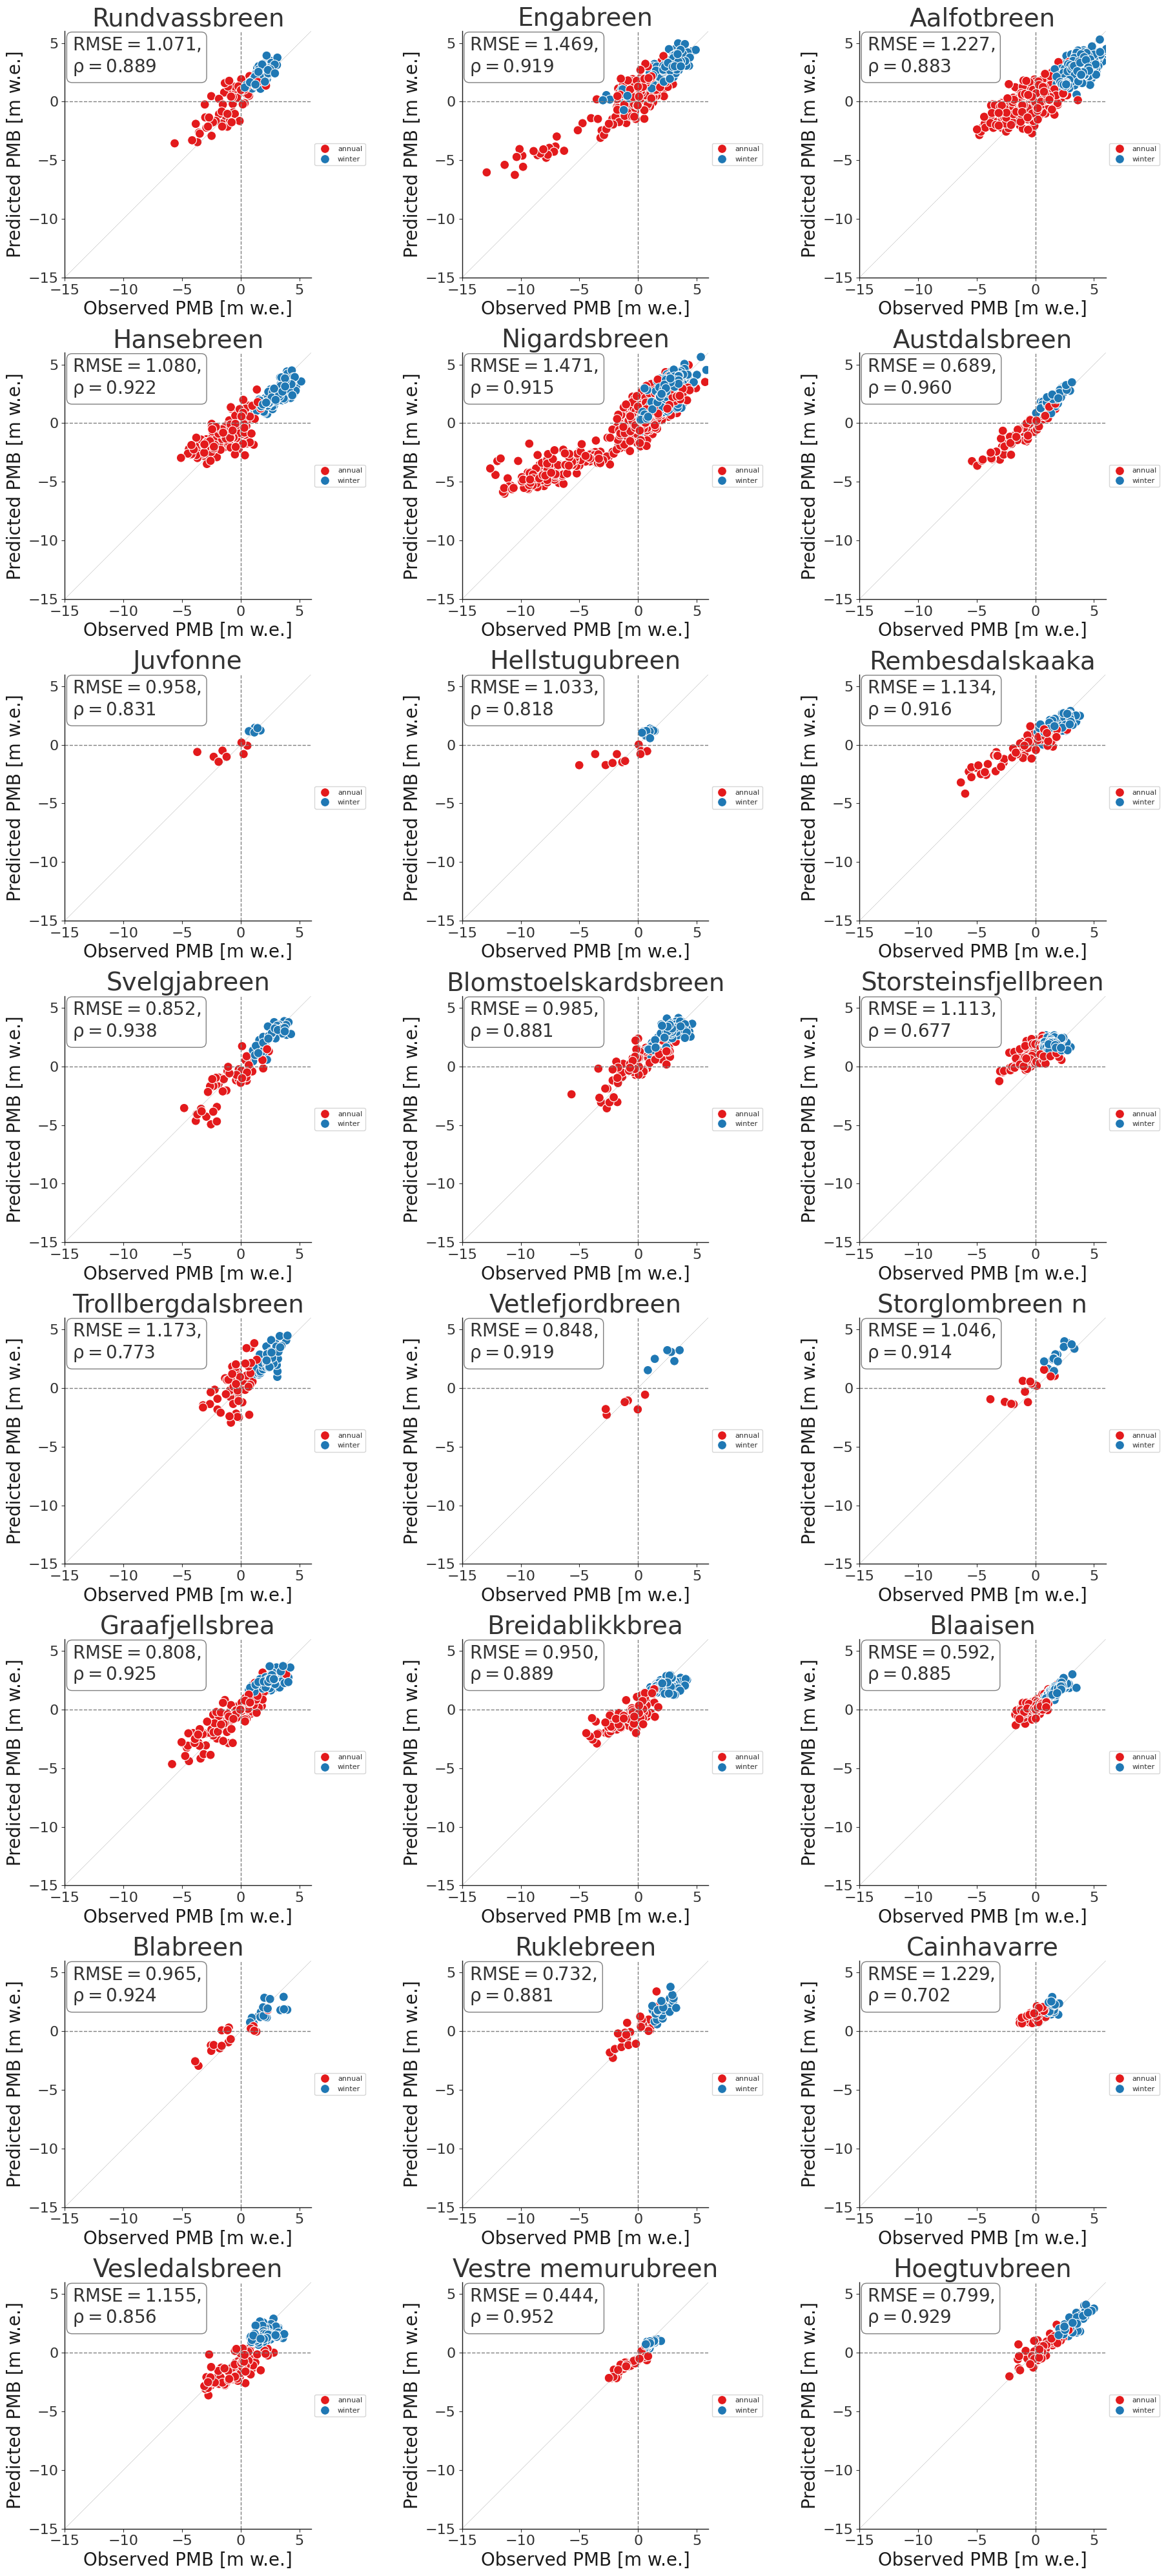

In [ ]:
PlotPredictions_NN(grouped_ids)
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))